In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision

import torchvision.models as models

import torch.optim as optim
torch.manual_seed(1) # set the random seed

import numpy as np

ModuleNotFoundError: No module named 'torch'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [6]:
transform = transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 resolution
    transforms.ToTensor()         # Convert the image to a tensor
])
newDatasetTrain = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/RiceImage/train',transform=transform)

newDatasetValidation = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/RiceImage/validation',transform=transform)



#I am choosing to do the typical 80/10/10 split of the data, since there are 2229 images, the division is not exact


In [7]:
# features = ... load precomputed alexnet.features(img) ...
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 150)
        self.fc3 = nn.Linear(150, 90)
        self.fc4 = nn.Linear(90, 50)
        self.fc5 = nn.Linear(50, 6)

    def forward(self, x):
        x = x.view(-1, 256) #flatten feature data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [8]:
alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 89.1MB/s]


In [9]:
use_cuda = False

In [7]:
def calculate_validation_error(modelCalc):
  error_over = 0

  validation_batches = torch.utils.data.DataLoader(features_validation, batch_size=1)

  for image,label in iter(validation_batches):
    if torch.argmax(modelCalc(image),dim=1).item() != label:
      error_over+=1

  return error_over/len(features_validation)


In [9]:
def trainModelLer(modelIn,lr,epochs):

  error, number = [],[]
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(modelIn.parameters(),lr=lr)

  train_batches = torch.utils.data.DataLoader(features_train, batch_size=1024,shuffle=True)
  torch.save(modelIn.state_dict(), 'best-model-parameters.pt')
  smallerError = calculate_validation_error(modelIn)

  for epoch in range(epochs):
    i = 0
    print("Currently on epoch: ",epoch)

    if(epoch % 100 == 0 and epoch != 0):
      lr = lr/2
      optimizer = optim.Adam(modelIn.parameters(),lr=lr)

    currentError = calculate_validation_error(modelIn)
    error.append(currentError)

    if(currentError<smallerError):
      torch.save(modelIn.state_dict(), 'best-model-parameters.pt')
      smallerError = currentError

    number.append(epoch)

    for featureOut,labels in iter(train_batches):
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        labels = labels.cuda()
      #############################################

      featureOut = torch.from_numpy(featureOut.detach().numpy())
      out = modelIn(featureOut)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch


      i += 1

  return error, number



In [12]:
features_train = []

for image, label in iter(newDatasetTrain):

  appendList = []

  if use_cuda and torch.cuda.is_available():
    image = image.cuda()

  newImage = alexnet.features(image)

  appendList.append(newImage)
  appendList.append(label)

  features_train.append(appendList)



In [13]:
features_validation = []

for image, label in iter(newDatasetValidation):

  appendList = []

  if use_cuda and torch.cuda.is_available():
    image = image.cuda()

  newImage = alexnet.features(image)

  appendList.append(newImage)
  appendList.append(label)

  features_validation.append(appendList)

In [14]:
modelTrans = ANNClassifier()

CUDA is not available.  Training on CPU ...
Currently on epoch:  0
Currently on epoch:  1
Currently on epoch:  2
Currently on epoch:  3
Currently on epoch:  4
Currently on epoch:  5
Currently on epoch:  6
Currently on epoch:  7
Currently on epoch:  8
Currently on epoch:  9
Currently on epoch:  10
Currently on epoch:  11
Currently on epoch:  12
Currently on epoch:  13
Currently on epoch:  14
Currently on epoch:  15
Currently on epoch:  16
Currently on epoch:  17
Currently on epoch:  18
Currently on epoch:  19
Currently on epoch:  20
Currently on epoch:  21
Currently on epoch:  22
Currently on epoch:  23
Currently on epoch:  24
Currently on epoch:  25
Currently on epoch:  26
Currently on epoch:  27
Currently on epoch:  28
Currently on epoch:  29
Currently on epoch:  30
Currently on epoch:  31
Currently on epoch:  32
Currently on epoch:  33
Currently on epoch:  34
Currently on epoch:  35
Currently on epoch:  36
Currently on epoch:  37
Currently on epoch:  38
Currently on epoch:  39
Curren

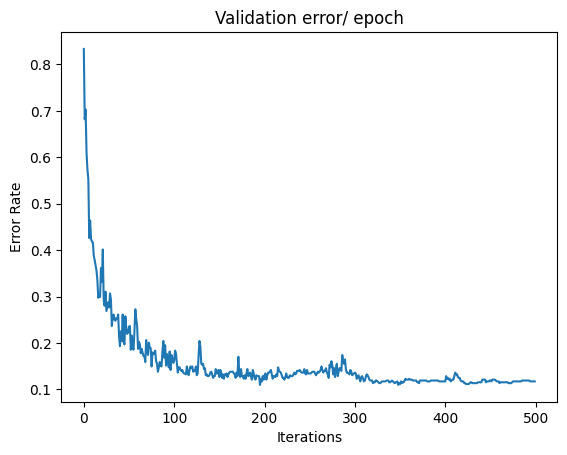

In [15]:
if use_cuda and torch.cuda.is_available():
  modelTrans.cuda()
  alexnet.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

error, epoch = trainModelLer(modelTrans,0.01,500)

plt.title("Validation error/ epoch")
plt.plot(epoch, error, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Error Rate")
plt.show()

In [21]:
best_model = ANNClassifier()
best_model.load_state_dict(torch.load('/content/best-model-parameters.pt'))
print(calculate_validation_error(best_model)) #On 120 epochs 12.6% error rate

0.10984848484848485


In [17]:
print(sum(p.numel() for p in modelTrans.parameters()))
print(sum(p.numel() for p in alexnet.features.parameters()))

122788
2469696


Truth value:  5
Predicted value:  5


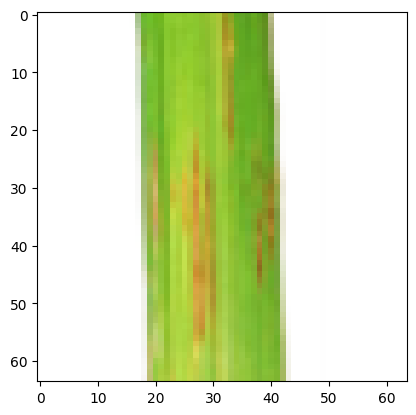

In [18]:
imageNum = 527
plt.imshow(torch.permute(newDatasetValidation[imageNum][0],(1,2,0)))
print("Truth value: ",newDatasetValidation[imageNum][1])
print("Predicted value: ",torch.argmax(best_model(alexnet.features(newDatasetValidation[imageNum][0])),dim=1).item())

In [19]:
def getWrongSamples(modelCalc):
  x = []
  y = []

  validation_batches = torch.utils.data.DataLoader(features_validation, batch_size=1)

  for image,label in iter(validation_batches):
    if torch.argmax(modelCalc(image),dim=1).item() != label:
      x.append(label)
      y.append(torch.argmax(modelCalc(image),dim=1).item())

  return x,y

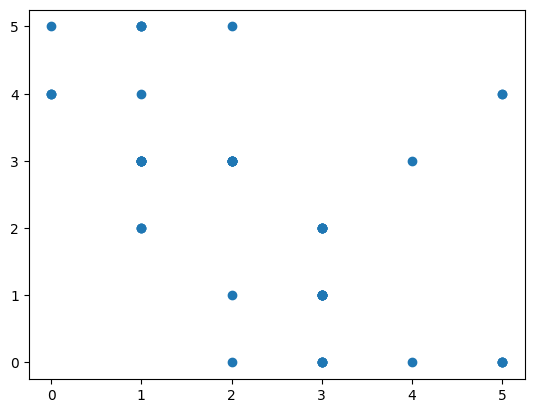

In [25]:
x,y = getWrongSamples(best_model)

plt.scatter(x, y)
plt.show()